# Featuring enginering for bag-of-words representation

### What you woul like to include:

- uni-grams DONE
- bi-grams DONE
- tri-grams DONE
- tf-idf (1,2,3 grams) DONE
- number of exclamation marks DONE - but not concatenated
- number of quesition marks DONE - but not concatenated
- number of @ DONE - but not concatenated
- number of # DONE - but not concatenated
---
- number of emojis
- Specific @'s and #'s as individual features
- Collections (of words that occure more often then random)
- Part-of-spech tagging (why thou?)

### how to reduce all that? DONE
- Forward selection w/ logistic regression or NB (the fasttest or the best) evaluated by F1 (or random forest if it is as fast... For interactions.)
- Backward selection w/ logistic regression or NB (the fastest or the best) evaluated by F1 (or random forest if it is as fast... For interactions.)

- Sklearn has a procidure for feature slecetions with trees through feature importance.... Hmm..

### What can exclude before F/B feature selection to minimize O: DONE
- High frequency stopwords
- low frequency rareties and clutter. 1 tweet?
- Number?

### What about tf-idf?: DONE
Can it just be seen as some weigted n-gram?


### And what about PCA's?
- These do belong in before the feature selections.
- But you cna easily set some threshold for explained variance
- But where.... Maybe.. Can I create PCA on sub sets.... looping over all 1, but only a comparable batch of 0.
- Btu there no security that you will identify the same PCA's each time..

### To undersample/over sample ot not to under/oversmpel... DONE
- Do oversmple..
- Do all three ting... Dne you need som very easily mentained functions.
- Starting with the under sampling, you allso get a felling of how long the feature selection will take
- Maybe you only undersample for the feature selection - if tit takes a long time. The do all three when you do the final test?
- But it should still be under 10000 obs if you oversample. Should not be a problem.

In [1]:
# Basics -----------------------------------------------------

import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
import regex

# NLTK -----------------------------------------------------

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#stop_words = set(nltk.corpus.stopwords.words("english"))

# SK learn --------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sampling -------------------------------------------------

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

# DATA ------------------------------------------------------
df = pd.read_csv("labled_tweets.csv", index_col=0)

# Split for inner and outer layer:

In [2]:
y = df["lacking_dem_pref"]
X = df["text"]

# Outer layer
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X, y, test_size=0.20, random_state=42)

# inner layer
X_train, X_test, y_train, y_test = train_test_split(X_train_out, y_train_out, test_size=0.20, random_state=42)


# Term document matrix:

### Preproccesing

In [3]:
def prep(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    return wordlist

words = prep(df.text.to_string())
len(words)

57554

In [4]:
# For all text (why did you use wordF)
dist = nltk.FreqDist(words)
print("all tweets:")
print(dist.most_common(20))
print("\n","-------------------")

all tweets:
[('...', 4987), ('@', 2183), ('the', 2089), (':', 1519), ('to', 1268), (',', 1041), ('#', 958), ('rt', 952), ('a', 874), ('i', 627), ('of', 626), ('.', 616), ('is', 511), ('in', 488), ('and', 480), ('on', 471), ('for', 427), ('we', 332), ('you', 320), ('with', 290)]

 -------------------


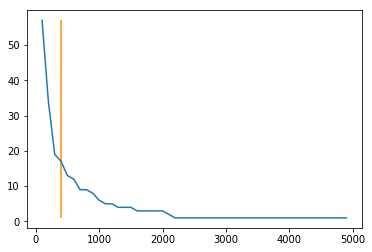

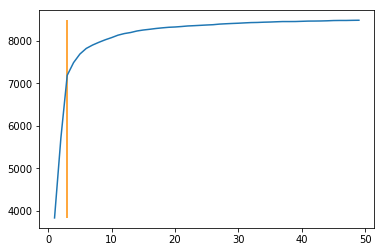

In [5]:
# Reduction potantial:

# High frequency words
high_freq = {}

high_range = np.arange(100,5000,100)

for i in high_range:
    temp_freq = []
    for k, v in dist.items():
        if v >= i:
            temp_freq.append(k)
    high_freq["freq"+str(i)] = len(temp_freq)

max_high = max(list(high_freq.values()))
min_high = min(list(high_freq.values()))
    
plt.plot(high_range, list(high_freq.values()))
plt.vlines(400, min_high,max_high, colors= "darkorange")

plt.show()


# Low frecuncy words
low_freq = {}

low_range = np.arange(1,50,1)

for i in low_range:
    temp_freq = []
    for k, v in dist.items():
        if v <= i:
            temp_freq.append(k)
    low_freq["freq"+str(i)] = len(temp_freq)

max_low = max(list(low_freq.values()))
min_low = min(list(low_freq.values()))

plt.plot(low_range, list(low_freq.values()))
plt.vlines(3, min_low,max_low, colors= "darkorange")

plt.show()

In [6]:
high_freq_remove = []
low_freq_remove = []

for i, j in dist.items():
    if j >= 400:
        high_freq_remove.append(i)
    elif j <= 3:
        low_freq_remove.append(i)
        
print(len(low_freq_remove))
print(len(high_freq_remove))

full_freq_remove = high_freq_remove + low_freq_remove

print(len(full_freq_remove))

7190
17
7207


In [7]:
# remove singeltons and doubles:
short = []

for i in words:
    if len(i)<=2:
        short.append(i)

short_remove = list(set(short))

full_remove = short_remove + full_freq_remove

In [8]:
stop_words = []#["goptaxscam"] # for now no stopwords

def prep2(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    wordlist = [w for w in wordlist if w not in full_remove and w not in stop_words]
    return wordlist

words_processed = prep2(df.text.to_string())
len(words_processed)

19479

In [9]:
# For all text (why did you use wordF)
dist = nltk.FreqDist(words_processed)
print("all tweets:")
print(dist.most_common(20))
print("\n","-------------------")

all tweets:
[('you', 320), ('with', 290), ('goptaxscam', 289), ('great', 258), ('this', 248), ('will', 247), ('our', 243), ('tax', 225), ('today', 221), ('that', 215), ('are', 213), ('amp', 169), ('have', 168), ('thank', 161), ('http', 159), ('from', 150), ('just', 144), ('house', 133), ('republican', 126), ('all', 115)]

 -------------------


## Count vectorizer

In [10]:
unigram_vectorizer = CountVectorizer(tokenizer=prep2) 
bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1C = unigram_vectorizer.transform(X_test)

X_dtm_1C = (X_train_dtm_1C, X_test_dtm_1C)

X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2C = bigram_vectorizer.transform(X_test)

X_dtm_2C = (X_train_dtm_2C, X_test_dtm_2C)

X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3C = trigram_vectorizer.transform(X_test)

X_dtm_3C = (X_train_dtm_3C, X_test_dtm_3C)

# --------------------------------------------

X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

X_dtm_allC = (X_train_dtm_allC, X_test_dtm_allC)

# ------------------------------------------
X_dtm_C = [X_dtm_1C, X_dtm_2C, X_dtm_3C, X_dtm_allC]

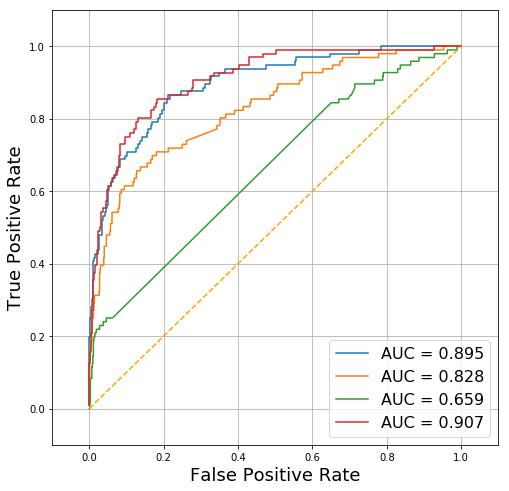

In [11]:
plt.figure(figsize=[8,8])

for i in X_dtm_C:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

## tf-idf vectorizer

In [12]:
unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1T = unigram_vectorizer.transform(X_test)

X_dtm_1T = (X_train_dtm_1T, X_test_dtm_1T)


X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2T = bigram_vectorizer.transform(X_test)

X_dtm_2T = (X_train_dtm_2T, X_test_dtm_2T)


X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3T = trigram_vectorizer.transform(X_test)

X_dtm_3T = (X_train_dtm_3T, X_test_dtm_3T)

# -----------------------------------------------
X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

X_dtm_allT = (X_train_dtm_allT, X_test_dtm_allT)

# ------------------------------------------

X_dtm_T = [X_dtm_1T, X_dtm_2T, X_dtm_3T, X_dtm_allT]

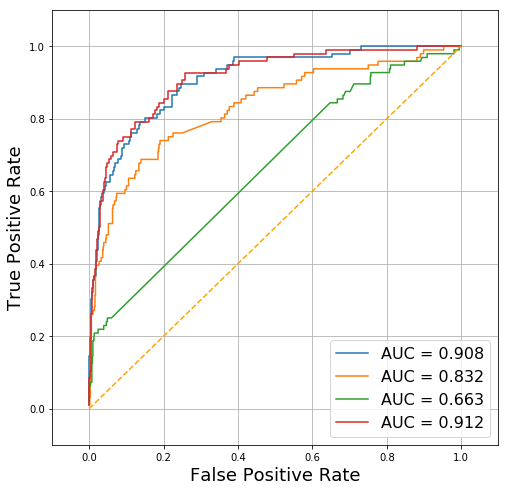

In [13]:
plt.figure(figsize=[8,8])

for i in X_dtm_T:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

## Combined

In [14]:
X_train_dtm_all = sparse.hstack([X_train_dtm_allT, X_train_dtm_allC])
X_test_dtm_all = sparse.hstack([X_test_dtm_allT, X_test_dtm_allC])

X_dtm_all = (X_train_dtm_all, X_test_dtm_all)

X_dtm = [X_dtm_all]

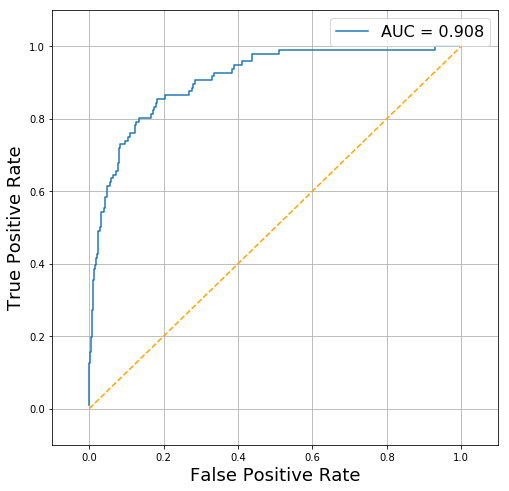

In [15]:
plt.figure(figsize=[8,8])

for i in X_dtm:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

In [16]:
X_train_dtm_all.shape

(3263, 119450)

## Conclusion
So for the BoW, if you should choose one, you should choose td-idf with 1,2,3 - grams 
men det kommer self også an på hvor lang tid sk feature selection tager?

----
# Number of !, ?, @, and # (and emojis?)

In [17]:
def count_symb(X):
    count_att = []
    count_exclamation = []
    count_question = []
    count_hashtags = []

    for i in X:
        count_att.append(i.count("@"))
        count_exclamation.append(i.count("!"))
        count_question.append(i.count("?"))
        count_hashtags.append(i.count("#"))

    count_df = pd.DataFrame([count_att,count_exclamation,count_question,count_hashtags]).T
    count_df.columns = {"count_att":0,"count_exclamation":1,"count_question":2,"count_hashtags":3}

    return(sparse.csr_matrix(count_df))
    

In [18]:
X_train_count_symb = count_symb(X_train)
X_test_count_symb = count_symb(X_test)

In [19]:
X_train_dtm_all_count = sparse.hstack([X_train_dtm_all, X_train_count_symb])
X_test_dtm_all_count = sparse.hstack([X_test_dtm_all, X_test_count_symb])

In [20]:
X_dtm_all_count = (X_train_dtm_all_count, X_test_dtm_all_count)
X_dtm_count = [X_dtm_all_count]

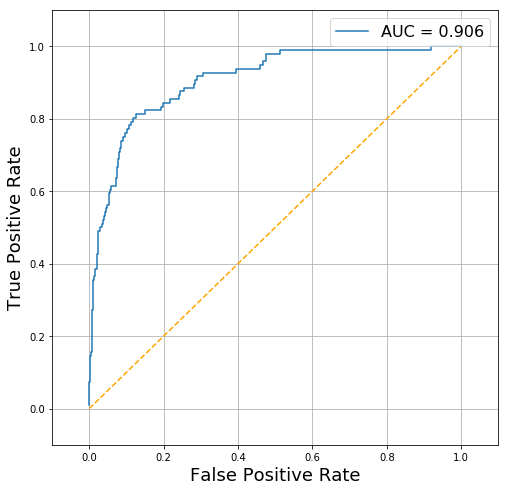

In [21]:
plt.figure(figsize=[8,8])

for i in X_dtm_count:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Oversample test:

In [22]:
ros = RandomOverSampler(random_state=42)
sos = SMOTE(random_state=42)

X_dtm_all_count_train_Roversampled, y_Roversampled = ros.fit_sample(X_dtm_all_count[0], y_train)
X_dtm_all_count_train_Soversampled, y_Soversampled = sos.fit_sample(X_dtm_all_count[0], y_train)

X_dtm_all_count_Rover = (X_dtm_all_count_train_Roversampled, X_test_dtm_all_count)
X_dtm_all_count_Sover = (X_dtm_all_count_train_Soversampled, X_test_dtm_all_count)



X_dtm_samples = [X_dtm_all_count_Rover,X_dtm_all_count_Sover]
y_samples = [y_Roversampled,y_Soversampled]

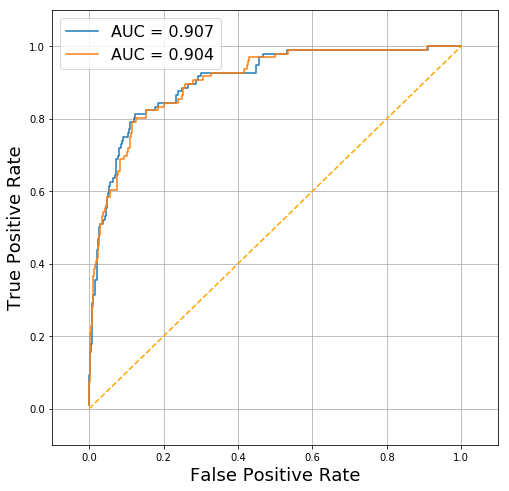

In [23]:
plt.figure(figsize=[8,8])

for i in X_dtm_samples:
    c = 0
    clf_lg = LogisticRegression().fit(i[0], y_samples[c])
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))
    c += 1

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Feature selction

In [24]:
X_dtm_all_count_train_Roversampled.shape

(5848, 119454)

In [25]:
clf_lg = LogisticRegression().fit(X_dtm_all_count_train_Roversampled, y_Roversampled)

model = SelectFromModel(clf_lg, prefit=True)
X_new_train = model.transform(X_dtm_all_count_train_Roversampled) #It works becouse you have allready fitted the logistic regression on the trainset
print(X_new_train.shape)

X_new_test = model.transform(X_test_dtm_all_count) #It works becouse you have allready fitted the logistic regression on the trainset
print(X_new_test.shape)

(5848, 27586)
(816, 27586)


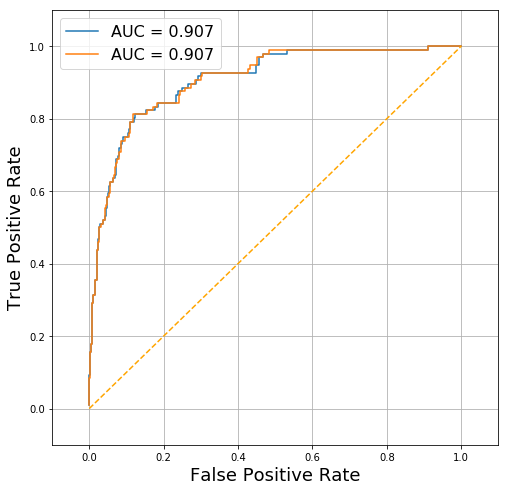

In [26]:
X_dtm_all_count_Rover_LF = (X_new_train, X_new_test)

X_dtm_samples = [X_dtm_all_count_Rover,X_dtm_all_count_Rover_LF]
y_samples = [y_Roversampled,y_Roversampled]

plt.figure(figsize=[8,8])

for i in X_dtm_samples:
    c = 0
    clf_lg = LogisticRegression().fit(i[0], y_samples[c])
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))
    c += 1

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Singular Value Dicomposition

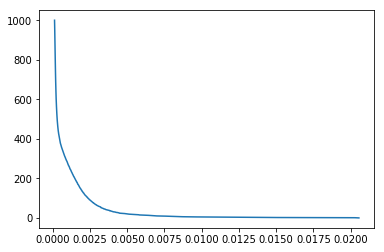

759


In [84]:
n_comp = 1000 # Fordi eller tager det en krig

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_new_train)

# ------------------------------------------------------------------

svd_exp_var = sorted(svd.explained_variance_ratio_, reverse = True) # should be sotred, but now we are sure
svd_range = np.linspace(0,len(svd_exp_var),n_comp)
plt.plot(svd_exp_var,svd_range)
# xticks

plt.show()

# -----------------------------------------------------------------

c = 0

for c in range(0,1000):
    if svd.explained_variance_ratio_[:c].sum() >= 0.90:
        print(c)
        break


# --------------------------------------------------------------
        
n_comp = c # et her kunne være fedt at gøre mere systematisk..

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_new_train)
        
svd_train = svd.transform(X_new_train)
svd_test = svd.transform(X_new_test)

In [86]:
print(svd_train.shape)
print(svd_test.shape)

(5848, 759)
(816, 759)


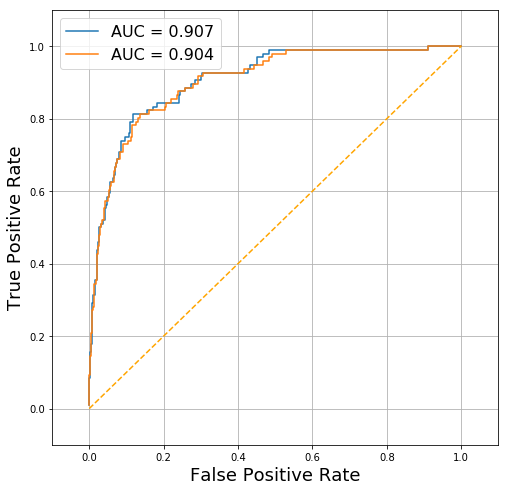

In [88]:
X_svd = (svd_train, svd_test)

X_dtm_samples = [X_dtm_all_count_Rover_LF,X_svd]
y_samples = [y_Roversampled,y_Roversampled]

plt.figure(figsize=[8,8])

for i in X_dtm_samples:
    c = 0
    clf_lg = LogisticRegression().fit(i[0], y_samples[c])
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))
    c += 1

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()

# Så er det bare at få merged, transformed test2, og pickled it. Og så synes jeg du skal skrive afsnittet. Om ikke andet et godt udkast. Og få lavet nogle pæne og ordenlige grafer :) 

# ROD ---------